**DETECTING AMBULANCE USING TWO PRE-TRAINED MODELS NAMELY YOLO AND RESNET101**


IMPORTING REQUIRED LIBRARY'S

In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import struct
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from matplotlib import pyplot
from numpy import expand_dims
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image 
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

LOADING YOLO AND RESNET MODELS

In [7]:
modelyolo = load_model('/content/drive/My Drive/YOLOModel.h5')  #WE SHARED WEIGHTS DRIVE LINK ON README.MD FILE 
modelresnet =tf.keras.applications.ResNet101()


WE DEFINE ALL FUNCTIONS AND CLASSES FOR VEHICLE DETECTION.WE TAKE CO-ORDINATES OF DETECTED IMAGE AND DRAWING BOUND-BOX AROUND DETECTED IMAGE AND STORE IN V_BOX AND IT'S LABEL IN V_LABEL

In [8]:
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 #DEFINING A LOSS FUNCTION
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
 
# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = expand_dims(image, 0)
	return image, width, height
 
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 # define the labels for which yolo was trained 
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier","toothbrush"]


WRITING A FUNCTION WHICH TAKES AN IMAGE AND RETURNS TRUE IF AMBULANCE IS DETECTED OTHERWISE FALSE

WORKING OF FUNCTION-->
      FIRST PRE-PROCESS THE IMAGE AND FEED TO THE YOLO MODEL,IT DETECTS ALL     FOUR WHEELER VEHICLES AS EITHER TRUCK OR CAR AND STORES CO-ORDINATES IN V_BOXES AND RESPECTIVE LABEL(MEANS EITHER TRUCK OR BUS) IN V_LABELS. THEN WE TAKE CO-ORDINATES OF BOXES DETECTED AS EITHER CAR OR TRUCK ,CROP IT AND PRE-PROCESS IT AND FEED TO THE RESNET MODEL AND CHECK IF IT IS AMBULANCE OR NOT.
##      *NOTE=YOLO IS NOT PRE-TRAINED FOR DETECTING AMBULANCE SO IT DETECTS AS CAR OR TRUCK, ON THE OTHER HAND RESNET IS TRAINED TO DETECT AMBULANCE SO WE USE COMBINATION OF 2 MODELS TO GET THE RESULT WITH LESS EFFORT AND BETTER ACCURACY.
##      *NOTE2=WE CAN TRAIN YOLO ITSELF TO DETECT AMBULANCE USING CUSTOM OBJECT DETECTION BUT IT REQUIRES LOT OF IMAGES UNDER DIFFERENT SCENARIOS AND WE COULDN'T GET ENOUGH DATA TO TRAIN THE MODEL. SO WE OPTED OUT FOR USING ANOTHER MODEL AND SOLVE THE PROBLEM. 



In [12]:
def checkambulance(photo_filename):#PASS IMAGE PATH AS ARGUMENT
  input_w, input_h = 416, 416
  from keras.preprocessing.image import image
  # load and prepare image
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  # make prediction
  yhat = modelyolo.predict(image)
  anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
  class_threshold = 0.6
  boxes = list()
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)
  
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  im=io.imread(photo_filename)
  plt.imshow(im)
  for i in range(len(v_boxes)):
    if(v_labels[i]=='truck' or v_labels[i]=='bus'):
      box=v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax      #EXTRACT CO-ORDINATES OF BOXES
      width, height = x2 - x1, y2 - y1
      if(height==0):
        height=1
      image1 =im[y1:y1+height,x1:x1+width]      #CROP BOX AND FEED TO ANOTHER MODEL
      image1 = cv2.resize(image1,(224,224), interpolation = cv2.INTER_AREA)
      img = np.expand_dims(image1, axis=0)
      result=modelresnet.predict(img)
      label = decode_predictions(result,top=15)
      for i in range(15):
        if(label[0][i][1]=='ambulance'):
          plt.imshow(image1)
           
          return True
  return False

# ** show image which we are passing to our model**

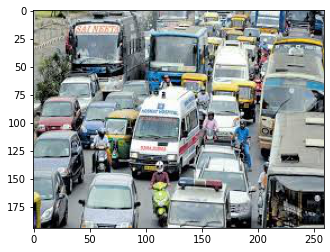

In [22]:
IMAGE_PATH='/content/drive/My Drive/ambulancedataset/Train/ambulance/da8.jpg'
im=io.imread(IMAGE_PATH)
plt.imshow(im)

SEND AN IMAGE PATH TO THE FUNCTION AND PRINT THE BOX WHERE AMBULANCE IS DETECTED(JUST FOR CLARIFICATION PURPOSE-DEMO)

ambulance detected


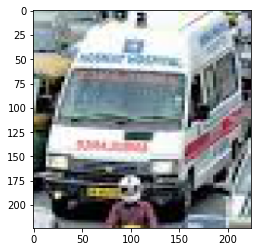

In [23]:
IMAGE_PATH='/content/drive/My Drive/ambulancedataset/Train/ambulance/da8.jpg'
if checkambulance(IMAGE_PATH):
  print("ambulance detected")
